# 03. 분류

In [116]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)    
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = "Classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3.1 MNIST

In [91]:
import urllib.request
import gzip
import numpy as np

# Download the MNIST dataset from Yann LeCun's website
url = "http://yann.lecun.com/exdb/mnist/"
files = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]

for file in files:
    urllib.request.urlretrieve(url + file, "../datasets/MNIST/" + file)

# Load the downloaded dataset into numpy arrays
with gzip.open("../datasets/MNIST/train-images-idx3-ubyte.gz", "rb") as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
with gzip.open("../datasets/MNIST/train-labels-idx1-ubyte.gz", "rb") as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open("../datasets/MNIST/t10k-images-idx3-ubyte.gz", "rb") as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
with gzip.open("../datasets/MNIST/t10k-labels-idx1-ubyte.gz", "rb") as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

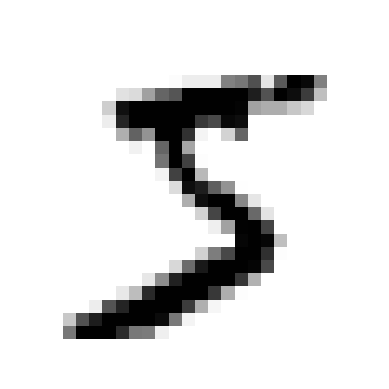

In [93]:
plt.imshow(X_train[0], cmap='binary')
plt.axis("off")
plt.show()

In [68]:
y_train[0]

5

In [69]:
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

## 3.2 이진 분류기 훈련

In [70]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [96]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [72]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [73]:
sgd_clf.predict([X_train[0]])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [74]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [75]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [76]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.3.2 오차 행렬

In [77]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

행이 실제 클래스, 열이 예측한 클래스

In [80]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

In [84]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [86]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### 3.3.4 정밀도/재현율 트레이드오프

In [97]:
some_digit = X_train[0]

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [99]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [100]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [102]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [107]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

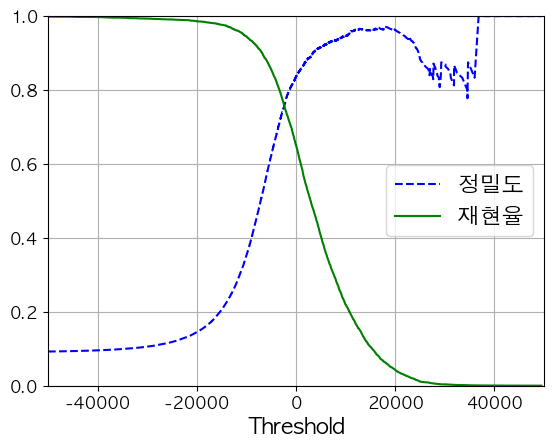

In [117]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1]) 
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [119]:
threshold_90_precision = threshold[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439566

In [120]:
y_train_pred_90 = y_scores >= threshold_90_precision

In [121]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [122]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선